# Resampling approaches to the imbalanced problem

In [2]:
from __future__ import division, print_function
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from builtins import range

import numpy as np
import pandas as pd
from keras.utils import np_utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, log_loss, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.preprocessing import LabelEncoder

# result = pd.read_pickle("/home/zhendi/pm/scripts/result_non_split_rmnum.pkl")
result = pd.read_pickle("/home/zhendi/pm/scripts/result_non_split_strict.pkl")
labels = result[["Class"]] - 1

In [3]:
# better way
def buildFeatures_split(df):
    """This is a function to extract all features (gene, variation, and text), 
    df argument should be a pandas dataframe with only Gene, Variation, TEXT, and Class columns"""
    # make a copy
    temp = df.copy()
    labels = temp["Class"] - 1
    del temp["Class"]

    # onehot encode gene and variation
    print("Onehot Encoding...")
    temp = pd.get_dummies(temp, columns=["Gene", "Variation"], drop_first=True)
    
    
    # split the data to training data and testing data
    print("Splitting...")
    X_train, X_test, y_train, y_test = train_test_split(
        temp, labels, test_size=0.2, random_state=5, stratify = labels
    )
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    svdT = TruncatedSVD(n_components=390, n_iter=5)

    # Tfidf vectorize TEXT
    tfidf = TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        analyzer="word",
        stop_words="english",
        token_pattern=r"\w+",
    )
    print("Tfidf Vectorizing...")
    temp_tfidf_xtrain = svdT.fit_transform(tfidf.fit_transform(X_train["TEXT"]))
    print("xtrain tfidf shape: ", temp_tfidf_xtrain.shape)
    temp_tfidf_xtest = svdT.transform(tfidf.transform(X_test["TEXT"]))
    print("xtest tfidf shape: ", temp_tfidf_xtest.shape)

    # Count vectorize TEXT
    cvec = CountVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        analyzer="word",
        stop_words="english",
        token_pattern=r"\w+",
    )
    print("Count Vectorizing...")
    temp_count_xtrain = svdT.fit_transform(cvec.fit_transform(X_train["TEXT"]))
    print("xtrain cvec shape: ", temp_count_xtrain.shape)
    temp_count_xtest = svdT.transform(cvec.transform(X_test["TEXT"]))
    print("xtest cvec shape: ", temp_count_xtest.shape)

    del X_train["TEXT"]
    del X_test["TEXT"]

    # rename the colnames
    print("Renaming...")
    tempc_xtrain = list(X_train.columns)
    tempc_xtest = list(X_test.columns)

    for i in range(np.shape(temp_tfidf_xtrain)[1]):
        tempc_xtrain.append("tfidf_" + str(i + 1))
    for i in range(np.shape(temp_tfidf_xtest)[1]):
        tempc_xtest.append("tfidf_" + str(i + 1))

    for i in range(np.shape(temp_count_xtrain)[1]):
        tempc_xtrain.append("count_" + str(i + 1))
    for i in range(np.shape(temp_count_xtest)[1]):
        tempc_xtest.append("count_" + str(i + 1))

    X_train = pd.concat(
        [
            X_train,
            pd.DataFrame(temp_tfidf_xtrain, index=X_train.index),
            pd.DataFrame(temp_count_xtrain, index=X_train.index),
        ],
        axis=1,
    )
    X_test = pd.concat(
        [
            X_test,
            pd.DataFrame(temp_tfidf_xtest, index=X_test.index),
            pd.DataFrame(temp_count_xtest, index=X_test.index),
        ],
        axis=1,
    )
    X_train.columns = tempc_xtrain
    X_test.columns = tempc_xtest

    print("Finished.")

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = buildFeatures_split(
    result[["Gene", "Variation", "TEXT", "Class"]]
)

Onehot Encoding...
Splitting...
(2656, 3259) (665, 3259) (2656,) (665,)
Tfidf Vectorizing...
xtrain tfidf shape:  (2656, 390)
xtest tfidf shape:  (665, 390)
Count Vectorizing...
xtrain cvec shape:  (2656, 390)
xtest cvec shape:  (665, 390)
Renaming...
Finished.


In [4]:
# pd.to_pickle((X_train, y_train, X_test, y_test), "/home/zhendi/pm/scripts/resample_data_split4baseline_strict.pkl")
# X_train, y_train, X_test, y_test = pd.read_pickle( "/home/zhendi/pm/scripts/resample_data_split4baseline_strict.pkl")


In [5]:

df_X_train = X_train.copy()
df_X_train['Class'] = y_train
df_X_test = X_test.copy()
df_X_test['Class'] = y_test


## Baseline

In [6]:
# X_train, y_train, X_test, y_test = pd.read_pickle( "/home/zhendi/pm/scripts/resample_data_split4baseline_strict.pkl")



def evaluate_features(X, y, X_test, y_test, clf=None):

    if clf is None:
        clf = RandomForestClassifier(n_estimators=400, random_state = 5, n_jobs = -1)

    probas = cross_val_predict(
        clf,
        X,
        y,
        cv=StratifiedKFold(n_splits=3),
        n_jobs=-1,
        method="predict_proba",
        verbose=2,
    )
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]

    print("Cross validation on training data: ")
    print("Log loss: {}".format(log_loss(y, probas)))
    print("Accuracy: {}".format(balanced_accuracy_score(y, preds)))
    print('f1score: {}'.format(f1_score(y, preds, average = 'micro')))

    print("Validation on testing data: ")
    clf.fit(X, y)
    ytest = clf.predict(X_test)
    yprobas_test = clf.predict_proba(X_test)
    print("Log loss: {}".format(log_loss(y_test, yprobas_test)))
    print("Accuracy: {}".format(balanced_accuracy_score(y_test, ytest)))
    print('f1score: {}'.format(f1_score(y_test, ytest, average = 'micro')))

evaluate_features(X_train, y_train, X_test, y_test)

# Cross validation on training data: 
# Log loss: 1.3043531922895704
# Accuracy: 0.4947690264523213
# f1score: 0.6355421686746988

# Validation on testing data: 
# Log loss: 1.116404955301456
# Accuracy: 0.5350690829081902
# f1score: 0.6706766917293233

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s finished
Cross validation on training data: 
Log loss: 1.3795442587887174
Accuracy: 0.4829926178643152
f1score: 0.6359186746987951
Validation on testing data: 
Log loss: 1.196023582675107
Accuracy: 0.5284083015643508
f1score: 0.6601503759398496


## Class Count and Split

In [7]:
# Class count: class 6 is the most, class 7 is the least for both training data and testing data
df_X_train.Class.value_counts().sort_values
# df_X_test.Class.value_counts().sort_values

<bound method Series.sort_values of 6    762
3    549
0    454
1    361
5    220
4    194
2     71
8     30
7     15
Name: Class, dtype: int64>

In [8]:
count_class_0, count_class_1, count_class_2, count_class_3, count_class_4, count_class_5, count_class_6, count_class_7, count_class_8 = df_X_train.Class.value_counts().sort_index()

print(count_class_6)
print(count_class_7)

762
15


In [9]:
# Divide by class
df_class_0 = df_X_train[df_X_train['Class'] == 0]
df_class_1 = df_X_train[df_X_train['Class'] == 1]
df_class_2 = df_X_train[df_X_train['Class'] == 2]
df_class_3 = df_X_train[df_X_train['Class'] == 3] 
df_class_4 = df_X_train[df_X_train['Class'] == 4]
df_class_5 = df_X_train[df_X_train['Class'] == 5]
df_class_6 = df_X_train[df_X_train['Class'] == 6] # most
df_class_7 = df_X_train[df_X_train['Class'] == 7] # least
df_class_8 = df_X_train[df_X_train['Class'] == 8]


## Random up Sampling

Random over-sampling:
7    762
3    762
6    762
2    762
5    762
1    762
8    762
4    762
0    762
Name: Class, dtype: int64


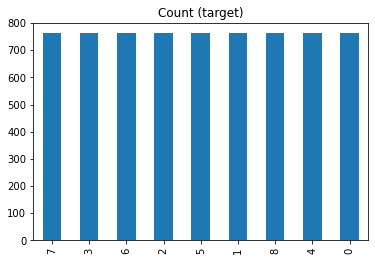

In [10]:
df_class_0_over = df_class_0.sample(count_class_6, replace=True)
df_class_1_over = df_class_1.sample(count_class_6, replace=True)
df_class_2_over = df_class_2.sample(count_class_6, replace=True)
df_class_3_over = df_class_3.sample(count_class_6, replace=True)
df_class_4_over = df_class_4.sample(count_class_6, replace=True)
df_class_5_over = df_class_5.sample(count_class_6, replace=True)
df_class_7_over = df_class_7.sample(count_class_6, replace=True)
df_class_8_over = df_class_8.sample(count_class_6, replace=True)


df_train_over = pd.concat([df_class_0_over, df_class_1_over, df_class_2_over, df_class_3_over, df_class_4_over,df_class_5_over, df_class_6, df_class_7_over, df_class_8_over], axis=0)

print('Random over-sampling:')
print(df_train_over.Class.value_counts())

df_train_over.Class.value_counts().plot(kind='bar', title='Count (target)')

In [11]:
y_train = df_train_over['Class']
del df_train_over['Class']
X_train = df_train_over

In [12]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
encoded_test_y = np_utils.to_categorical((le.inverse_transform(y_test)))


In [13]:


evaluate_features(X_train, y_train, X_test, y_test)

# Cross validation on training data: 
# Log loss: 0.42451396848021816
# Accuracy: 0.9284047827354915
# f1score: 0.9284047827354914
# Validation on testing data: 
# Log loss: 1.6780803656137624
# Accuracy: 0.5973130480577082
# f1score: 0.6601503759398496

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished
Cross validation on training data: 
Log loss: 0.48078177807428746
Accuracy: 0.9270924467774861
f1score: 0.9270924467774861
Validation on testing data: 
Log loss: 1.7733442629632505
Accuracy: 0.5814359446468222
f1score: 0.6451127819548872


## imblearn library

In [14]:
import imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y_train)

In [15]:
evaluate_features(X_ros, y_ros, X_test, y_test)

# Cross validation on training data: 
# Log loss: 0.42451396848021816
# Accuracy: 0.9284047827354915
# f1score: 0.9284047827354914
# Validation on testing data: 
# Log loss: 1.6780803656137624
# Accuracy: 0.5973130480577082
# f1score: 0.6601503759398496


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s finished
Cross validation on training data: 
Log loss: 0.48078177807428746
Accuracy: 0.9270924467774861
f1score: 0.9270924467774861
Validation on testing data: 
Log loss: 1.7733442629632505
Accuracy: 0.5814359446468222
f1score: 0.6451127819548872


## Over-sampling: SMOTE

In [16]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy = 'auto')
X_sm, y_sm = smote.fit_sample(X_train, y_train)

In [17]:
evaluate_features(X_sm, y_sm, X_test, y_test)


# Cross validation on training data: 
# Log loss: 0.42451396848021816
# Accuracy: 0.9284047827354915
# f1score: 0.9284047827354914
# Validation on testing data: 
# Log loss: 1.6780803656137624
# Accuracy: 0.5973130480577082
# f1score: 0.6601503759398496

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s finished
Cross validation on training data: 
Log loss: 0.48078177807428746
Accuracy: 0.9270924467774861
f1score: 0.9270924467774861
Validation on testing data: 
Log loss: 1.7733442629632505
Accuracy: 0.5814359446468222
f1score: 0.6451127819548872


## Over-sampling followed by under-sampling

In [18]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy = 'auto')
X_smt, y_smt = smt.fit_sample(X_train, y_train)

evaluate_features(X_smt, y_smt, X_test, y_test)


# Cross validation on training data: 
# Log loss: 0.4193741176318106
# Accuracy: 0.9330736269724108
# f1score: 0.9335387323943662
# Validation on testing data: 
# Log loss: 1.7250979894933764
# Accuracy: 0.5860118374849917
# f1score: 0.6601503759398496


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s finished
Cross validation on training data: 
Log loss: 0.473950905659361
Accuracy: 0.9276366124252111
f1score: 0.9279648609077599
Validation on testing data: 
Log loss: 1.8214311079902497
Accuracy: 0.5906275150100488
f1score: 0.6451127819548872
